In [2]:
%matplotlib widget

In [3]:
import numpy as np
import xtrack as xt
import matplotlib.pyplot as plt

### Load lattice

In [4]:
env = xt.Environment()
env.call('../fccee_z_lattice.py')

### Load all matched quadrupoles and sextupoles strengths 

In [5]:
env.vars.load_json('strengths_quads_00_arc_cell.json')
env.vars.load_json('strengths_quads_01_ffccsyl.json')
env.vars.load_json('strengths_quads_02_ffccsxl.json')
env.vars.load_json('strengths_quads_03_ffccsyr.json')
env.vars.load_json('strengths_quads_04_ffccsxr.json')
env.vars.load_json('strengths_quads_05_ffds_lr.json')
env.vars.load_json('strengths_quads_06_straight.json')

env.vars.load_json('strengths_sext_00_arc_cell.json')
env.vars.load_json('strengths_sext_01_straight.json')
env.vars.load_json('strengths_sext_02_final_focus.json')

In [6]:
line = env['fccee_p_ring']

### First closed twiss 🎉🎉🎉

In [7]:
tw = line.twiss4d()

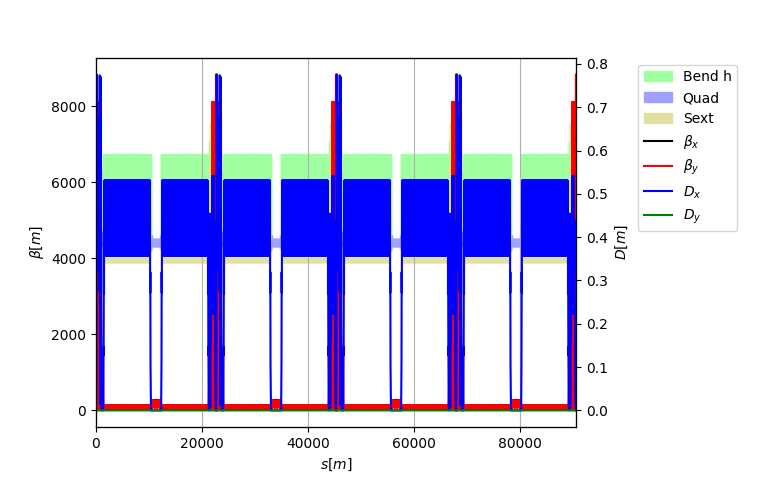

In [8]:
tw.plot()

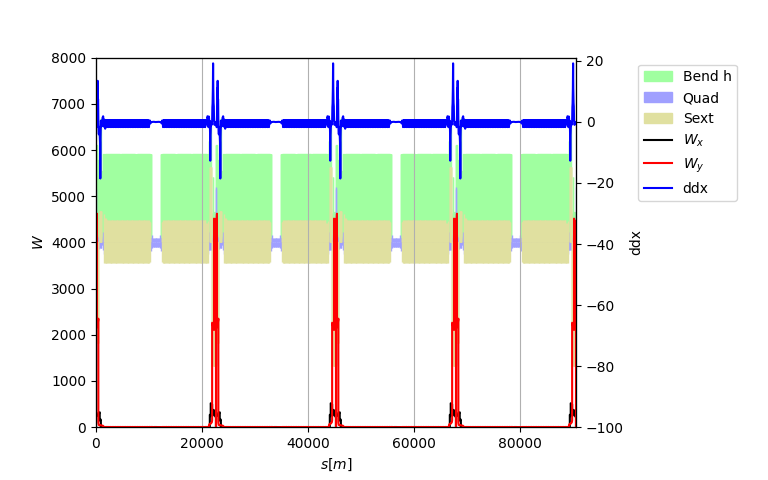

In [9]:
pp = tw.plot(yl='wx_chrom wy_chrom', yr='ddx')
pp.ylim(left_lo=0, left_hi=8000, right_lo=-100)

### Use MAD-NG to study RDT cancellations

In [10]:
line.replace_all_repeated_elements() # Not yet supported by Xsuite MAD-NG interface

In [11]:
tw_ng = line.madng_twiss(rdts=['f1200', 'f2100', 'f3000'])

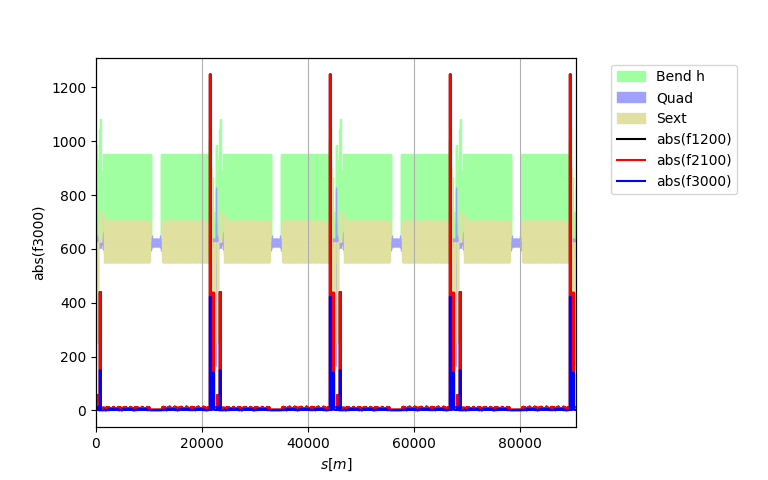

In [12]:
# Plot RDT
tw_ng.plot('abs(f1200) abs(f2100) abs(f3000)')

In [13]:
# High order chromaticities
tw_ng.d2q1_nf_ng

np.float64(193.43746246131366)

In [14]:
tw_ng.d3q2_nf_ng

np.float64(568284.5118210596)

In [15]:
# Anharmonicities
tw_ng.dqxdjx_nf_ng

np.float64(-45897.95713278804)

### Momentum acceptance

In [16]:
# RF ON!
line['rf_on'] = 1
line['rf_lag'] = 0.5

In [17]:
# Twiss 6d
tw6d = line.twiss()

print('qs', tw6d.qs)
print('zeta', tw6d.zeta[0])

qs 0.04952401889033936
zeta 0.0


Tracking:   0%|          | 0/50 [00:00<?, ?it/s]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
frac_lost: 0.429, at_turn_mean: 30.034 <--


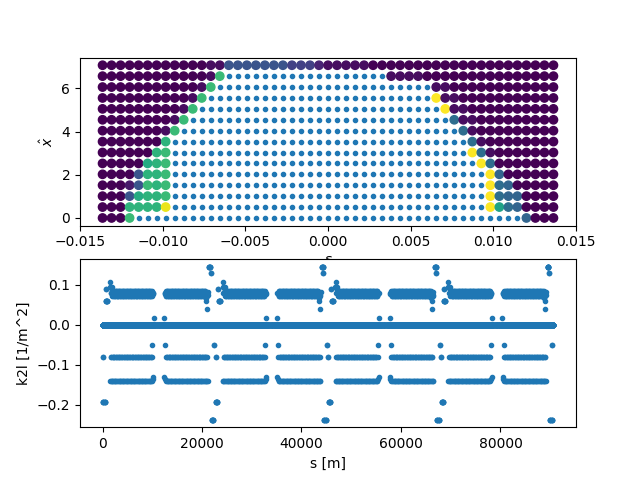

In [18]:
import sys
from momentum_acceptance import ActionMomentumAcceptance # reusing code from K. Skoufaris
nemitt_x = 6.33e-5
nemitt_y = 1.69e-7
energy_spread=3.9e-4
nn_y_r=15
max_y_r=10
global_xy_limit = 1e-2
num_turns = 50
act = ActionMomentumAcceptance(line,
            nemitt_x, nemitt_y, nn_y_r, max_y_r, energy_spread,
            global_xy_limit=global_xy_limit, num_turns=num_turns)

plt.figure()
_ = act.mom_acceptance(plot=True, with_progress=1)
plt.subplots_adjust(hspace=0.4)

### Perturb local chromaticity correction

In [19]:
### Remove the "phase sextupole"
line['ksdm1l'] = 0

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/50 [00:00<?, ?it/s]

frac_lost: 0.637, at_turn_mean: 21.1778 <--


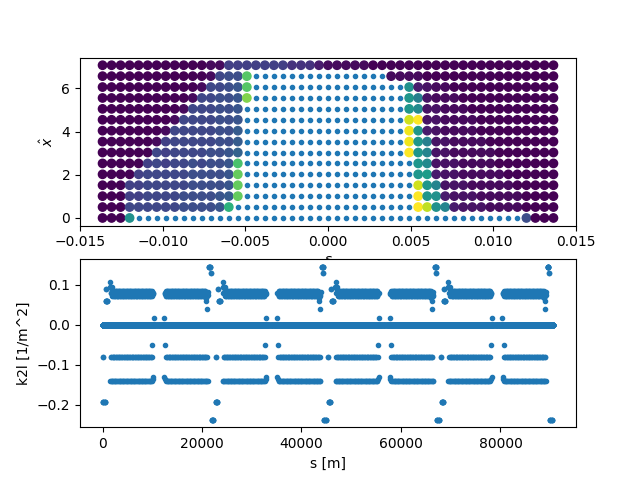

In [20]:
plt.figure()
_ = act.mom_acceptance(plot=True, with_progress=1)
plt.subplots_adjust(hspace=0.4)

In [22]:
# Use MAD-NG get third order chromaticity and RDTs
line['rf_on'] = 0
tw_ng_no_sdm1 = line.madng_twiss(rdts=['f1200', 'f2100', 'f3000'])

In [23]:
# Plot RDT
print(f"Without SDM1: Q'''y = {tw_ng_no_sdm1.d3q2_nf_ng:.3e}")
print(f"With    SDM1: Q'''y = {tw_ng.d3q2_nf_ng:.3e}")

Without SDM1: Q'''y = -5.224e+06
With    SDM1: Q'''y = 5.683e+05


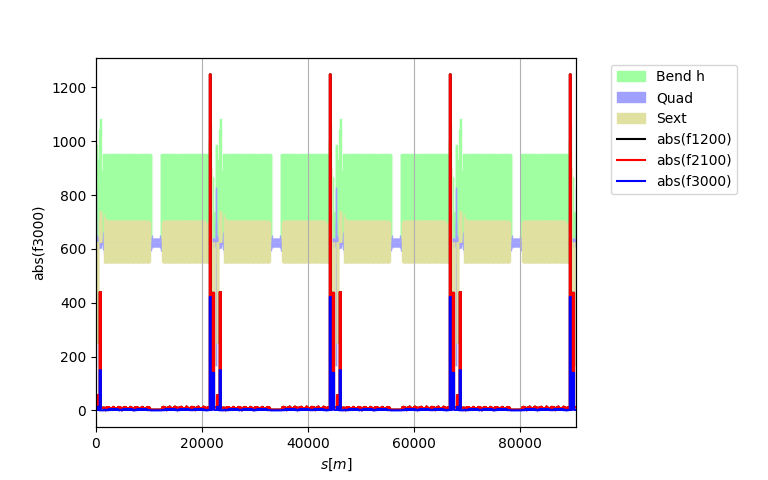

In [25]:
# Plot RDT
tw_ng_no_sdm1.plot('abs(f1200) abs(f2100) abs(f3000)')

### Match tune knobs

In [ ]:
tw0 = line.twiss4d()
opt = line.match_knob(
    run=False,
    method='4d',
    knob_name='dqy',
    knob_value_start=0,
    knob_value_end=5e-3,
    vary=xt.VaryList(['kqd1', 'kqf2', 'kqd3', 'kqf4', 'kqd5', 'kqf6'], step=1e-9),
    targets=xt.TargetSet(qx=tw0.qx, qy=tw0.qy+5e-3)
) 

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [ ]:
opt = line.match_knob(
    run=False,
    method='4d',
    knob_name='dqx',
    knob_value_start=0,
    knob_value_end=5e-3,
    vary=xt.VaryList(['kqd1', 'kqf2', 'kqd3', 'kqf4', 'kqd5', 'kqf6'], step=1e-9),
    targets=xt.TargetSet(qx=tw0.qx+5e-3, qy=tw0.qy)
) 
opt.solve()
opt.generate_knob()

### Change the tune using the knob

In [ ]:
line['dqx'] = 0.15